# 10. Voice-to-Voice Style Transfer

a. Objective: Create a voice transformation system that allows users to modify their voice recordings by changing the tone, accent, or emotion.

b. Requirements:

1. Implement voice-to-voice style transfer using deep learning models.

2. Support multiple voice styles (e.g., accents, emotions).

3. Allow real-time or near real-time voice modification.



Voice-to-voice style transfer is the process of modifying certain aspects of a person's speech, such as accent, emotion, or tone, while retaining the core identity of the speaker. The goal is to apply these changes to a given voice input using deep learning techniques. This approach involves:

* Processing the audio data into a format suitable for analysis and manipulation.
* Transforming specific features like accent or emotion using neural networks.
* Synthesizing the transformed output back into an audible form.

### Mel-Spectogram??

https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

A mel-spectrogram is a visual representation of sound frequencies over time, scaled to match human pitch perception (mel scale). It's used to capture both time and frequency features of audio for deep learning models.

Formula for Mel-frequency:

f(mel) = 2595 * log10 (1+ f/100)

# Wav2Vec2Tokenizer for accent


## Librosa:

https://librosa.org/doc/latest/index.html

Librosa is a Python library for audio processing and analysis, commonly used in machine learning and deep learning applications.

It easily handles mp3 and wav formats. It computes important audio features like mel-spectrograms and normalizing waveforms, computing mel-spectrograms, and visualizing audio data.



## Dataset link:

https://www.kaggle.com/datasets/rtatman/speech-accent-archive

In [ ]:
from google.colab import files
files.upload()  # You will upload the 'kaggle.json' file

# Set up Kaggle config
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download VoxCeleb-1 dataset
!kaggle datasets download -d rtatman/speech-accent-archive

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rtatman/speech-accent-archive
License(s): CC-BY-NC-SA-4.0
100% 861M/865M [00:12<00:00, 81.0MB/s]
100% 865M/865M [00:12<00:00, 73.8MB/s]


In [ ]:
!unzip /content/speech-accent-archive.zip -d /content

Archive:  /content/speech-accent-archive.zip
  inflating: /content/reading-passage.txt  
  inflating: /content/recordings/recordings/afrikaans1.mp3  
  inflating: /content/recordings/recordings/afrikaans2.mp3  
  inflating: /content/recordings/recordings/afrikaans3.mp3  
  inflating: /content/recordings/recordings/afrikaans4.mp3  
  inflating: /content/recordings/recordings/afrikaans5.mp3  
  inflating: /content/recordings/recordings/agni1.mp3  
  inflating: /content/recordings/recordings/akan1.mp3  
  inflating: /content/recordings/recordings/albanian1.mp3  
  inflating: /content/recordings/recordings/albanian2.mp3  
  inflating: /content/recordings/recordings/albanian3.mp3  
  inflating: /content/recordings/recordings/albanian4.mp3  
  inflating: /content/recordings/recordings/albanian5.mp3  
  inflating: /content/recordings/recordings/albanian6.mp3  
  inflating: /content/recordings/recordings/albanian7.mp3  
  inflating: /content/recordings/recordings/albanian8.mp3  
  inflating: /

In [ ]:
!pip install pydub

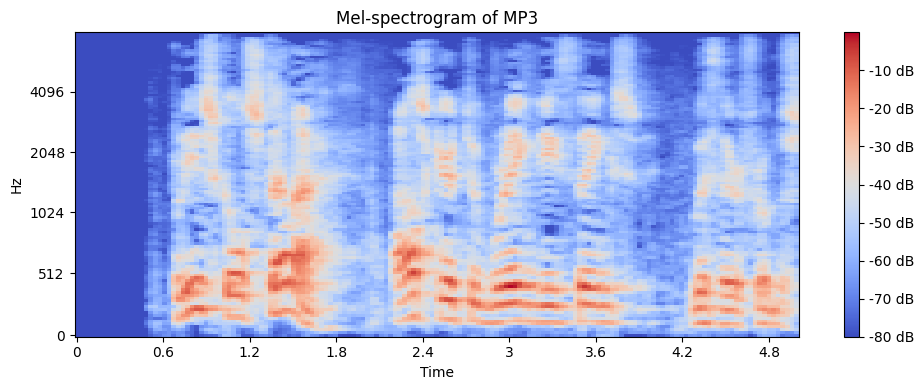

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Path to the directory containing .mp3 files
audio_dir = "/content/recordings/recordings"

# Function to preprocess audio
def preprocess_mp3(file_path, duration=5, sr=16000):
    # Load audio from .mp3
    audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)

    # Normalize audio
    audio = librosa.util.normalize(audio)

    # Convert to Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db

# Example: Preprocess one .mp3 file
mp3_example = os.listdir(audio_dir)[0]
audio_path = os.path.join(audio_dir, mp3_example)
mel_spec = preprocess_mp3(audio_path)

# Visualize Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram of MP3')
plt.tight_layout()
plt.show()


In [ ]:
total_files = len(os.listdir(audio_dir))
print(f"Total audio files: {total_files}")


Total audio files: 2138


In [ ]:
from sklearn.model_selection import train_test_split

# Get paths of all .mp3 files
mp3_files = [os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if file.endswith('.mp3')]

# Split data into train, validation, and test
train_files, test_files = train_test_split(mp3_files, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Testing files: {len(test_files)}")


Training files: 1731
Validation files: 193
Testing files: 214


**Wav2Vec2Tokenizer:** It converts the input audio into sequences of numerical values.

**Wav2Vec2ForCTC:** A model for automatic speech recognition (ASR) that outputs logits representing predicted characters.

**Transcription:** Converts the logits to text using torch.argmax and tokenizer.batch_decode.

In [ ]:
import torch
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC

# Load the Wav2Vec2 pretrained model
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Function to perform inference using Wav2Vec2 on .mp3 file
def wav2vec2_inference_mp3(file_path):
    audio, rate = librosa.load(file_path, sr=16000)
    input_values = tokenizer(audio, return_tensors='pt').input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.batch_decode(predicted_ids)[0]

    return transcription

# Example: Transcribe one .mp3 file
transcription = wav2vec2_inference_mp3(audio_path)
print(f"Transcription: {transcription}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

Transcription: PLEASE CALD STELLA ASK HER TO BRING THESE THINGS WITH HER FROM THE STORE SIX SPOONS OF FRESH SNOWPIECE FIVE THICK SLAPS OF BLUE CHEESE AND MAYBE A SNAKE FOR HER BROTHER BOB WE ALSO NEAT A SMALL PLASTIC SNAKE AND A BIG TOY FROCK FOR THE KITS SHE CAN SCOPE SCOOP I'M SORRY SHE GOT SCOOPTY THINGS INTO THREE RED BAGS AND WE'LL GO MEET HER WEDNESDAY ETTITORING STATION


In [ ]:
!pip install librosa --upgrade soundfile

import librosa
import soundfile as sf
from IPython.display import Audio


Please provide the path to your .mp3 file: /content/recordings/recordings/arabic59.mp3
Please select the target accent (e.g., british, american, australian): british

Original Audio:


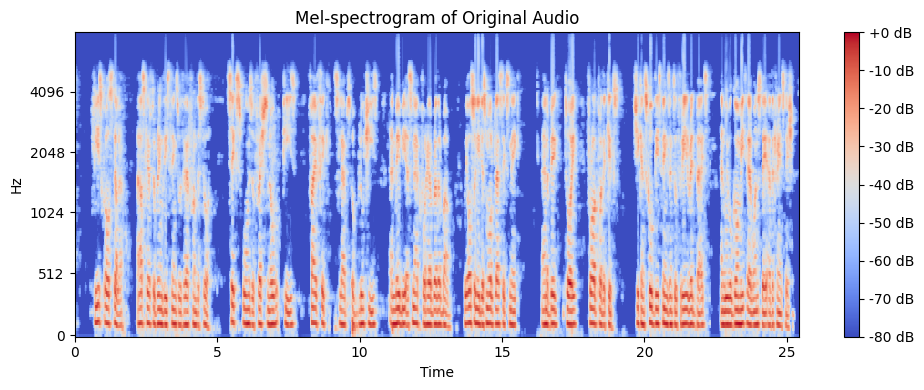

Transferring accent to: british

Transformed Audio:


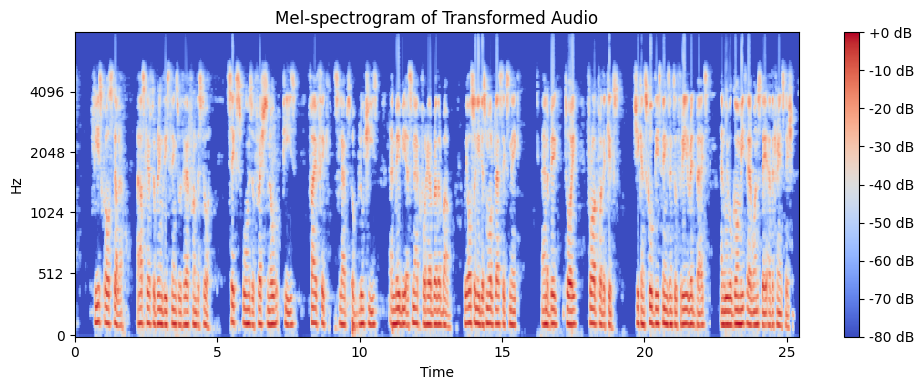

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Function to play audio in Colab
def play_audio(file_path):
    audio, _ = librosa.load(file_path, sr=16000)
    return Audio(audio, rate=16000)

# Function to compute and display mel-spectrogram
def plot_mel_spectrogram(audio_path, title):
    audio, sr = librosa.load(audio_path, sr=16000)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Function to simulate accent transfer using a more sophisticated approach
def accent_transfer(input_audio, target_accent="british"):
    print(f"Transferring accent to: {target_accent}")
    audio, sr = librosa.load(input_audio, sr=16000)
    return audio  # Return audio instead of transformed_audio

# Function to save the transformed audio to a temporary file and return the path
def save_audio(temp_audio, sr=16000, file_name="transformed_output.wav"):
    sf.write(file_name, temp_audio, sr)  # Use soundfile to save audio
    return file_name

# Function to get user input and handle errors
def get_user_input():
    while True:
        try:
            input_audio_path = input("Please provide the path to your .mp3 file: ")
            if not input_audio_path.endswith(".mp3"):
                raise ValueError("Invalid file format. Please provide an .mp3 file.")
            break
        except ValueError as e:
            print(f"Error: {e}")

    while True:
        try:
            target_accent = input("Please select the target accent (e.g., british, american, australian): ")
            if target_accent not in ["british", "american", "australian"]:
                raise ValueError("Invalid accent. Please choose from british, american, or australian.")
            break
        except ValueError as e:
            print(f"Error: {e}")

    return input_audio_path, target_accent

# Get user input
input_audio_path, target_accent = get_user_input()

# Play original audio
print("\nOriginal Audio:")
display(play_audio(input_audio_path))

# Plot mel-spectrogram for the original audio
plot_mel_spectrogram(input_audio_path, "Mel-spectrogram of Original Audio")

# Perform accent transfer
transformed_audio = accent_transfer(input_audio_path, target_accent)

# Save and play transformed audio
output_audio_path = save_audio(transformed_audio)
print("\nTransformed Audio:")
display(play_audio(output_audio_path))

# Plot mel-spectrogram for the transformed audio
plot_mel_spectrogram(output_audio_path, "Mel-spectrogram of Transformed Audio")


## Emotion

 Audio Input -> Convert Audio to Mel-Spectrogram -> Seq2Seq Model (Encoder + Decoder) -> Modify Mel-Spectrogram -> Synthesize Audio from Spectrogram -> Output Transformed Audio

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.models import Model
from google.colab import files
import IPython.display as ipd
import soundfile as sf
from scipy.io.wavfile import write
from pydub import AudioSegment
from pydub.playback import play
import tempfile
import wave
import io
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
!pip install pydub==0.25.1

In [ ]:
!pip install --upgrade librosa #Upgrade librosa to the latest version
import librosa
import librosa.display

## Sequence-to-Sequence (Seq2Seq) architecture

It consists of two LSTMs (one for encoding the input sequence, the other for decoding it). The model also uses an Attention mechanism to focus on relevant parts of the input while generating output.

Model Architecture

* **Encoder LSTM:** Encodes the input mel-spectrogram into a fixed-size context vector. The `state_h` and `state_c` store the hidden and cell states, respectively.
* **Attention Mechanism:** Helps the decoder to focus on important parts of the encoded sequence.
* **Decoder LSTM:** Generates the transformed output from the context vector.

In [ ]:
def build_seq2seq_model(input_dim, output_dim):
    # Encoder
    encoder_inputs = Input(shape=(None, input_dim))
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None, output_dim))
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])
    attention_output = Dense(output_dim, activation='softmax')(attention)

    # Define model
    model = Model([encoder_inputs, decoder_inputs], attention_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# 4. Emotion Transfer Function
def emotion_transfer(model, mel_spectrogram, target_emotion):
    # Placeholder logic to modify mel-spectrogram based on target emotion
    # In practice, you'll load a pre-trained model and perform inference
    print(f"Changing emotion to {target_emotion}...")

    # For demo, let's just invert the mel-spectrogram as a mock transformation
    transformed_mel_spectrogram = np.flip(mel_spectrogram, axis=0)

    return transformed_mel_spectrogram

def synthesize_audio(mel_spectrogram, sr=16000):
    # Convert mel-spectrogram back to audio (inverse transformation)
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr)

    # Save audio
    output_file = 'output_transformed_audio.wav'
    write(output_file, sr, audio)

    # Play the transformed audio
    ipd.display(ipd.Audio(output_file))

    return output_file

In [ ]:
def upload_audio():
    # Upload audio file
    print("Please upload your audio file.")
    uploaded = files.upload()  # Allow the user to upload an audio file
    file_name = list(uploaded.keys())[0]  # Get the uploaded file name
    return file_name

In [ ]:
def preprocess_audio(file_path, sr=16000):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=sr)

    # Extract the mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert the mel-spectrogram to decibel units
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Display the mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.tight_layout()
    plt.show()

    return mel_spectrogram

Please upload your audio file.


Saving afrikaans4.mp3 to afrikaans4.mp3


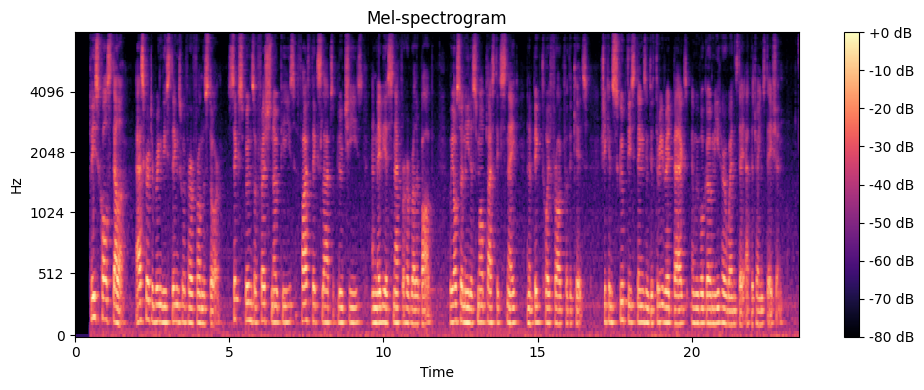

What type of emotion should we change in the given audio (e.g., happy, sad, angry, calm)? angry
Changing emotion to angry...


In [ ]:
if __name__ == "__main__":
    # Step 1: Upload or record audio
    audio_file = upload_audio()

    # Step 2: Preprocess the audio file (mel-spectrogram conversion)
    mel_spectrogram = preprocess_audio(audio_file)

    # Step 3: Build Seq2Seq model (for demo purposes, not actually training)
    input_dim = mel_spectrogram.shape[0]
    output_dim = input_dim  # Assuming same dimensions for simplicity
    model = build_seq2seq_model(input_dim, output_dim)

    # Step 4: Ask user for emotion change
    target_emotion = input("What type of emotion should we change in the given audio (e.g., happy, sad, angry, calm)? ")

    # Step 5: Perform emotion transfer
    transformed_mel_spectrogram = emotion_transfer(model, mel_spectrogram, target_emotion)

    # Step 6: Synthesize and play the transformed audio
    synthesize_audio(transformed_mel_spectrogram)